# Wellesley College Spectral Analysis

## Clara Berger '19 and Claire Cannatti '20
## Spring 2019

# Welcome spectographers!

You have just taken an image using our spectograph and have to go from the CCD image to a beautiful spectrum where you will be able to see what molecules are present in your object, in between you and your object, or even the doppler shift of an object movine away or towards you.

Follow these steps which may require you to change some numbers or load files on your own.

# Step 0 - Download and import all of your necessary packages

You should have **astropy, numpy, scipy and matplotlib** already if you use Anaconda.

If you do not, you may run:

### <font color = green> $ pip install < package > </font>

to install the necessary packages in your Terminal or Command Prompt.

### Everyone

We will be using the spectral analysis package specutils.

Again in Terminal or Command Prompt:

### <font color = green> $ pip install specutils </font>

When you have, run the cell below and check that every thing has been installed properly.

In [2]:
from astropy.io import fits # used to open and manipuate fits images
import numpy as np  # 
from matplotlib import pyplot as plt  # used in plotting graphs  
import matplotlib


%matplotlib notebook  
#an interactive interface for matplotlib, allowing you to zoom and read plot values

# Step 1 - Open the fits image
We first want to look at the CCD image of the spectrum, what we will call a 2D spectrum, and make sure we can correctly extract the 1D spectrum.

### Make sure the CCD image you wish to look at is as a .fits file inside the same directory where this jupyter notebook is saved.

In [9]:
'''
load in the fits image you would like to look at
'''


fits_image = fits.open('alphagem_062.fits') #read the fits file making sure it is in the same directory

fits_image.info()  # look at the contents of the image 

#each entry is an HDU, header data unit, and has information on the size of the image

hdu = fits_image[0]  # take the Primary HDU


## you could also look at the header to get information about RA, DEC, Grating and Tilt
#hdu.header  


Filename: alphagem_062.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (516, 516)   int16 (rescales to uint16)   


<IPython.core.display.Javascript object>


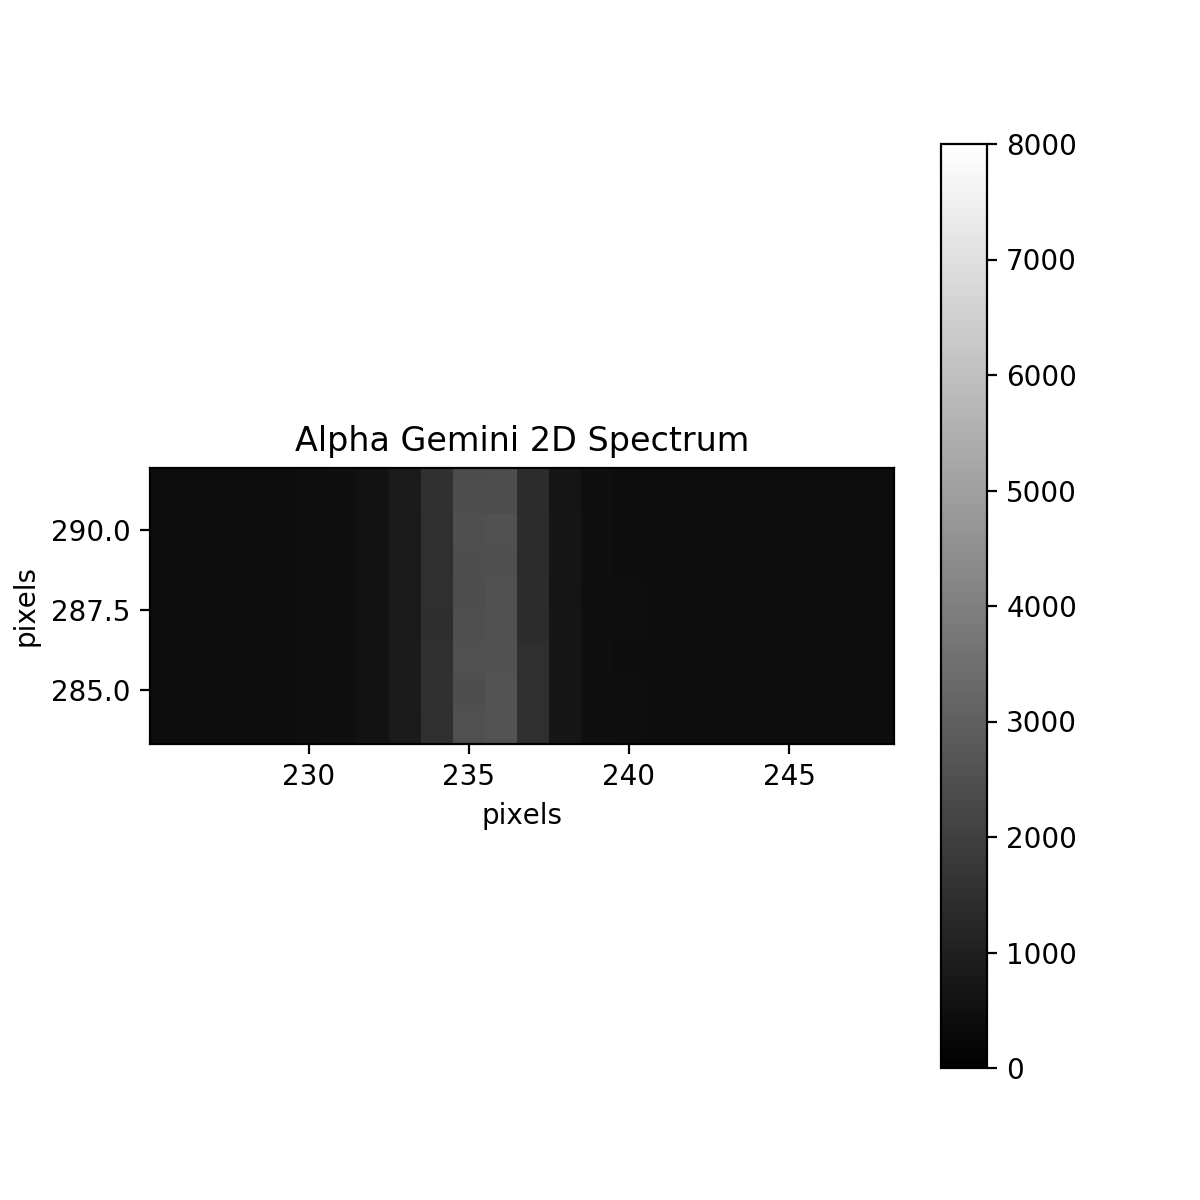

In [10]:
''' 
now display the fits image 

if you hover your mouse over each button at the bottom of the plot it will tell you what each does.
you will most likely use the square to zoom in to particular areas and the home to return to the
full view of the image
'''

img = hdu.data

plt.figure(figsize = (6,6)) # create a figure and set the size of the display 

## we will display the image with a color scale similar to what we can manipulate in DS9
# you may change vmin and vmax to alter the stretch of the color scale. closer numbers = fewer features usually
plt.imshow(img, origin = 'lower', vmin = 0, vmax = 8000,cmap='gray')  
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title('Alpha Gemini 2D Spectrum')
plt.colorbar()
plt.show()

# Step 2 - Extract 1D Spectrum
Extracting an intensity profile along the target's spectrum will give a 1D spectrum in pixels and intensity.


### Depending on how the spectrograph is built, you may see horizontally spread spectra rather than vertically spread spectra.
If this is the case, instead of a column averaging function, you will want a row averaging function, whose only difference would be **img[i,:]** instead of **img[:,i]**.

In [13]:
'''
where do you want to draw your box?

use the interactive spectrum above to select where you want your box to start (x value) and how 
wide you want it to be (how many pixels across is your target)

sometimes a wider box helps to reduce some noise but check what your 1D spectrum looks like at different 
box widths to make your decision
'''

## here we definte the column averaging function
def column_avg(img,start,width):
    column_sum = 0
    i = start
    
    while i<start+(width):
        column_sum += img[:,i]    #add all of the columns in your chosen box together
        
        i+=1
        
    column_avg = column_sum/(width)    # take the average of all those columns 
    
    return column_avg

<IPython.core.display.Javascript object>


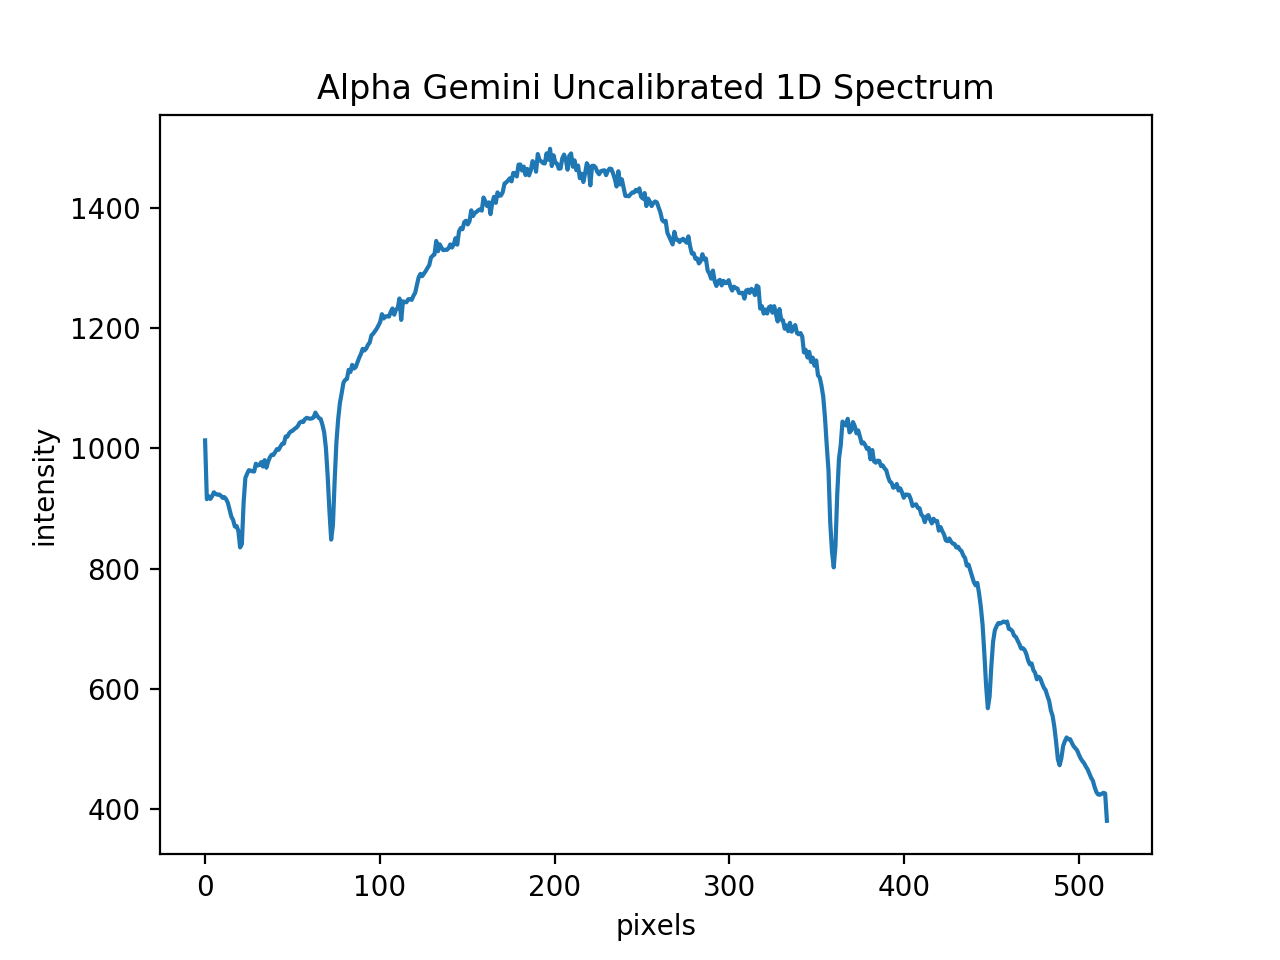

Text(0.5, 1.0, 'Alpha Gemini Uncalibrated 1D Spectrum')

In [12]:
'''
using the column_avg function on your 2D image take a slice 

now you may look at your 1D spectrum
'''

## here I have chosen to extract a box that begins at pixel 233 and is 8 pixels wide, which 
## encapsulates the full target spectrum
intensity_box_pix = column_avg(img,233,8)

# the pixels go from 0 to the length of the image youve taken
pixels = np.linspace(0,len(intensity_box_pix),len(intensity_box_pix))

plt.figure()
plt.plot(pixels,intensity_box_pix) # plot your pixels vs the intensity in your extracted box
plt.xlabel('pixels')
plt.ylabel('intensity')
plt.title('Alpha Gemini Uncalibrated 1D Spectrum')

## Step 1.1 - subtract background

<IPython.core.display.Javascript object>


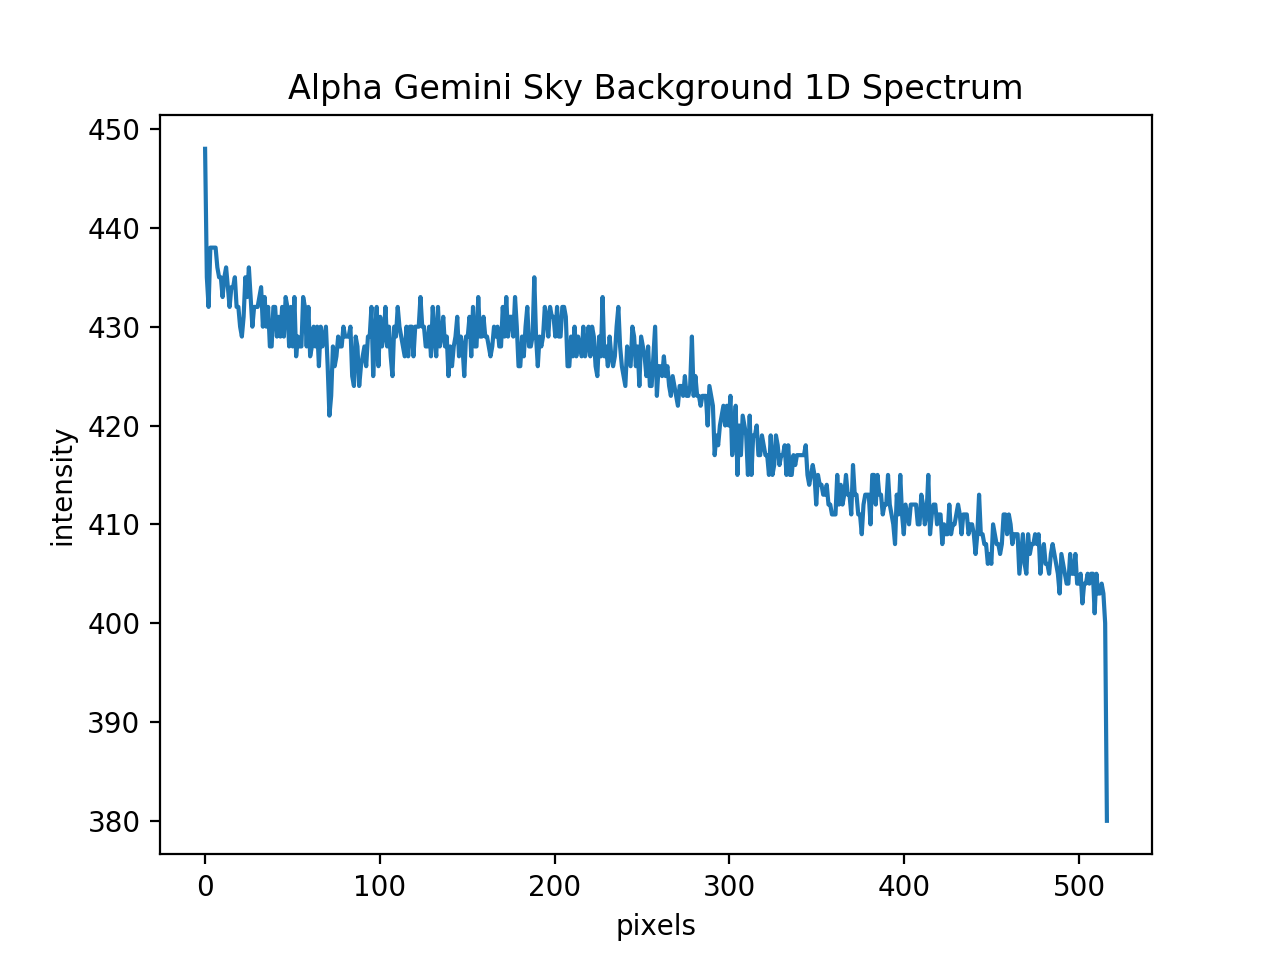

Text(0.5, 1.0, 'Alpha Gemini Sky Background 1D Spectrum')

In [15]:
'''
again using figure 1, select the pixel value that shows the sky background 

if we have specific fibers that intentionally sample the sky, please select pixel values that correspond to this
background spectrum
'''

## slice background spectrum (notice here we did not avg multiple columns but you can call column_avg if you choose)
## change slice number to correspond with your desired sky spectrum pixel value
background = img[:,242]

plt.figure()
plt.plot(pixels,background) # plot your pixels vs the intensity in your extracted box
plt.xlabel('pixels')
plt.ylabel('intensity')
plt.title('Alpha Gemini Sky Background 1D Spectrum')

<IPython.core.display.Javascript object>


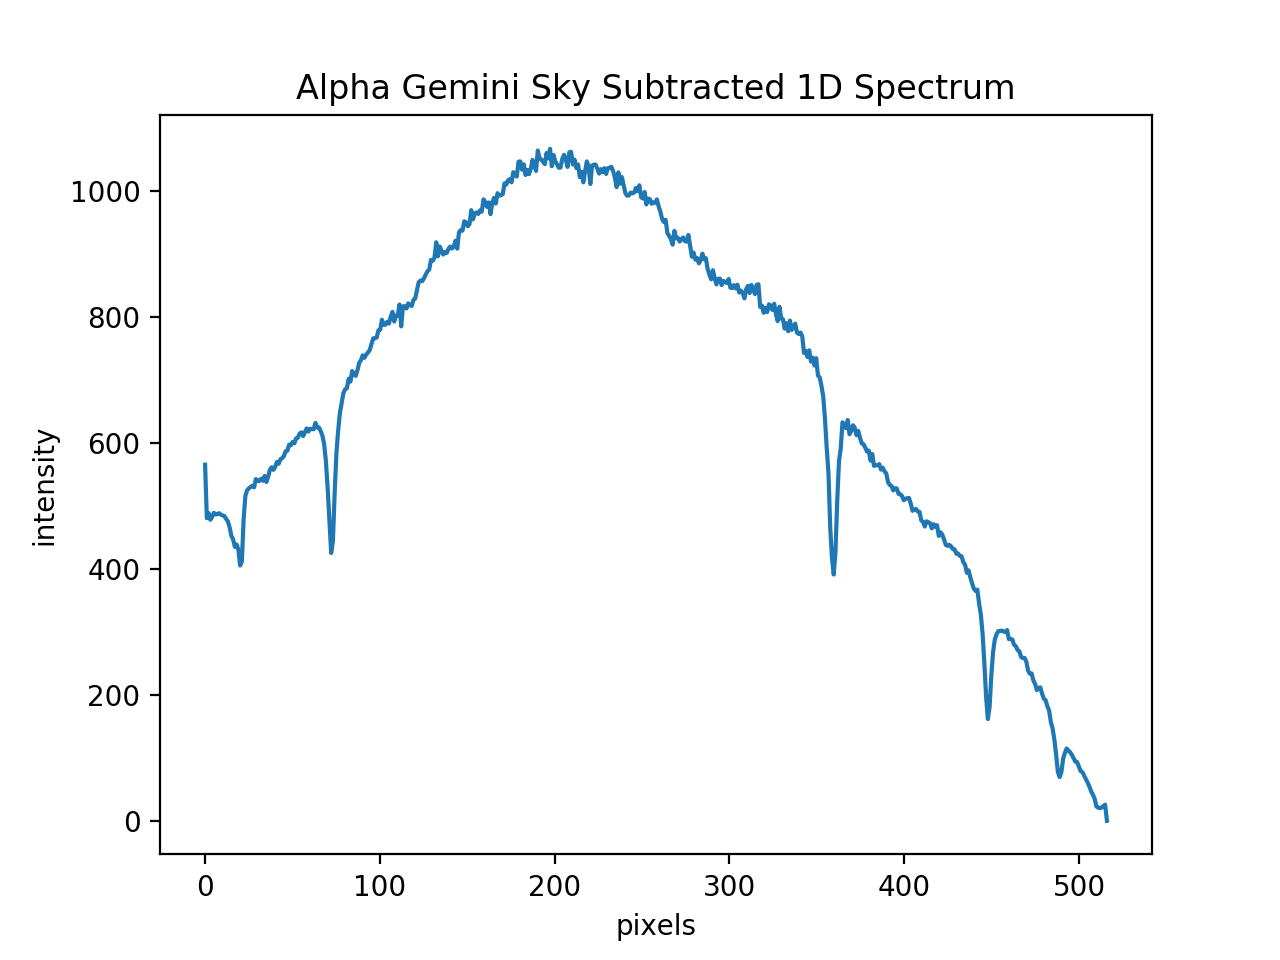

Text(0.5, 1.0, 'Alpha Gemini Sky Subtracted 1D Spectrum')

In [16]:
## subtract background from your spectrum and plot your sky subtracted spectrum
sky_subtracted = intensity_box_pix - background

plt.figure()
plt.plot(pixels,sky_subtracted) # plot your pixels vs the intensity in your extracted box
plt.xlabel('pixels')
plt.ylabel('intensity')
plt.title('Alpha Gemini Sky Subtracted 1D Spectrum')

# Step 3 - Wavelength solve your pixel axis
Now that you have a 1D spectrum in pixels and intensity, you want to calibrate your spectrum such that it is in wavelength and intensity.

Below is a spectrum of our HgNe lamps and what different peaks represent. You may use this as reference when selecting your calibration lines.

![HgNe](IMG_1152.jpg)

In [17]:
from astropy.io import fits
import numpy as np
import scipy.optimize as opt

## tkinter will allow us to build an interactive interface so that you can optimally calibrate wavelengths
import tkinter as tk
from tkinter import ttk
from tkinter import *


## set up your arrays to be filled in when you select your points from the plot
wavelengths = np.array([])
pixels = np.array([])
sigma = np.array([])

## we will fit a quadratic function between the pixels and wavelengths to calibrat the two
def func(x, a, b, c):
    return a + b*x + c*x*x

def onclick(event):
    print('xdata=%f' %(event.xdata))
    popup(str(event.xdata))

def popup(xdata):
    """
    This opens a dialog that lets the user enter wavelengths 
    associated with clicks on the plot.
    """
    global popupwindow
    popupwindow = Tk()
    popupwindow.wm_title("Log corresponding wavelength")

    # text labeling the dialog's function
    label = ttk.Label(popupwindow, text="What wavelength corresponds to the pixel " + xdata + "?")
    label.pack(side="top", fill="x", pady=10)
    
    label = ttk.Label(popupwindow, text="If entering manually, use the format 'label angstromWavelength A'.")
    label.pack(side="top", fill="x", pady=10)
    
    # dropdown or manual enter box for wavelength
    textfield = ttk.Combobox(popupwindow)
    textfield['values']=['H-alpha 6564 A', 'OIII 5007 A', 'H-beta 4861 A', 'HgNe 6402.0 A', 'HgNe 6334.0 A',
                         'HgNe 6266.0 A', 'HgNe 6143.0 A', 'HgNe 6096.0 A', 'HgNe 5945.0 A', 'HgNe 5852.0 A', 
                         'HgNe 5791.0 A', 'HgNe 5770.0 A', 'HgNe 5461.0 A']
    textfield.pack()
    
    # button that stores the wavelength and closes the dialog
    B1 = ttk.Button(popupwindow, text="Add Wavelength", 
                    command = lambda: addWavelength(xdata, textfield.get(), popupwindow))
    B1.pack()
    
    mainloop()


def addWavelength(xdata, wavelength, pop):
    """
    adds the pixel value and corresponding wavelength to 
    lists that will be used in the fitting.
    """
    global wavelengths
    global pixels
    global sigma

    wavelength = wavelength.split()
    wavelength = wavelength[1]
    
    # storing the data from the click event
    wavelengths = np.append(wavelengths, float(wavelength))
    pixels = np.append(pixels, float(xdata))
    sigma = np.append(sigma, 1.0)

    
    """
    This line works on Windows but breaks the program on Mac.
    Comment or don't depending on your OS. If it's commented, you
    need to manually X out of the dialog after clicking the 
    Add Wavelength button.
    """
#     pop.destroy()
    mainloop()



## Step 3.1 - Select calibration points

When you run this next cell it will produce a plot of the spectrum you've chosen to calibrate with. You will then click on an emission line that you know the wavelength of, this will bring a popup window prompting you to select, from a dropdown menu, which wavelength that particular peak represents.

### Mac users:
Once you have selected the correct line, press add wavelength, then x out of the pop up window and back into the jupyter where you will select your next calibration peak.

$*$ ** warning: if you accidentally click on the same peak twice, another box will pop up prompting you to input the wavelength for the same pixel value, you may close this box **

$*$ ** warning: if the box does not immediately pop up, check behind your browser window, in case it didn't come to the front of the screen **


### Windows users:
A mentioned above you may uncomment pop.distroy() which will automatically close the popup window once you hit add wavelengths, otherwise follow the mac users directions. 

<IPython.core.display.Javascript object>


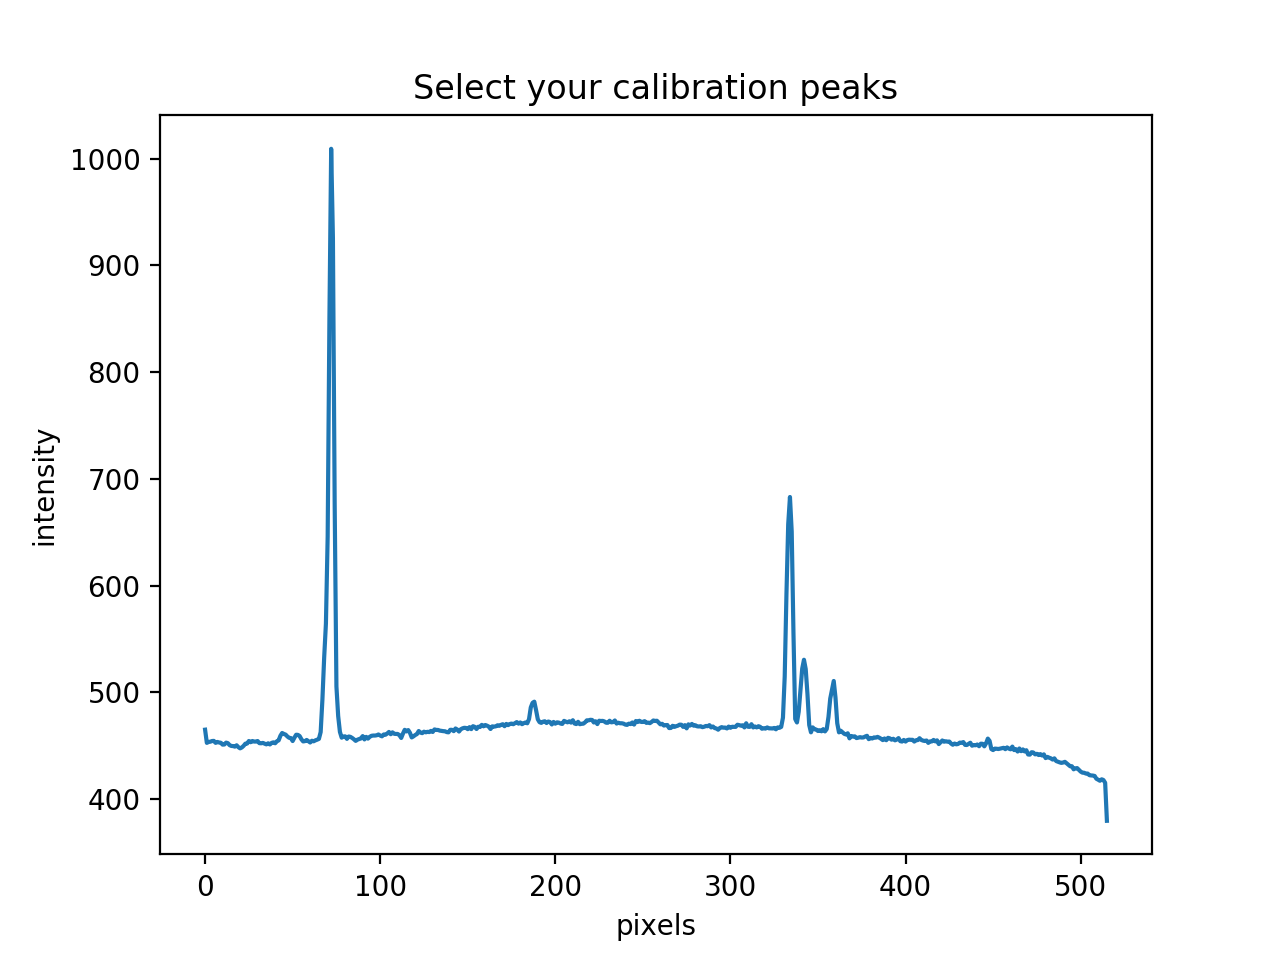

In [18]:
def main():

    """CHANGE THE IMAGE NAME HERE TO YOUR CALIBRATION IMAGE"""
    # hdus = fits.open('alphaaur.071.fits')
    hdus = fits.open('m42spec.078.fits')
    img = hdus[0].data

    #plt.figure()
    #plt.clf()
    #plt.imshow(img, origin = 'lower', vmin = 0, vmax = 10000)
    #plt.colorbar()

    #plt.show()

    fig = plt.figure()
    
    """CHANGE YOUR COLUMN SELECTION HERE BY CHANGING THE MIDDLE PIXEL AND WIDTH"""
    # plt.plot(column_avg(img, 300, 8))
    plt.plot(column_avg(img, 233, 8))
    plt.title('Select your calibration peaks')
    plt.xlabel('pixels')
    plt.ylabel('intensity')

    cid = fig.canvas.mpl_connect('button_press_event', onclick)

    plt.show()

    #sample data for h-alpa spectrum: IGNORE
    # pixeldata = np.array([71.0, 333.0, 359.0])
    # wavelengthdata = np.array([6463.0, 5007.0, 4861.0])
    # sigma = np.array([1.0, 1.0, 1.0])

    #sample data for HgNe spectrum: IGNORE
    # pixeldata = np.array([98.0, 110.0, 121.0, 141.0, 150.0, 175.0, 190.0, 200.0, 205.0, 257.0])
    # wavelengthdata = np.array([6402.0, 6334.0, 6266.0, 6143.0, 6096.0, 5945.0, 5852.0, 5791.0, 5770.0, 5461.0])
    # sigma = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

    #x0 = np.array([0.0, 0.0, 0.0])

       

    #for i in range(len(wavelengths)):
     #   print(str(pixels[i]) + " : " + str(wavelengths[i]))
        
    #return opt.curve_fit(func, pixels, wavelengths, x0, sigma)[0]

main()

In [19]:
'''
finally we will take our wavelength and pixel values and fit our quadratic function between the two"
'''
def final():
    x0 = np.array([0.0, 0.0, 0.0])
    
    print('pixel   :   wavelength')
    for i in range(len(wavelengths)):
        
        print(str(pixels[i]) + " : " + str(wavelengths[i]))
        
    return opt.curve_fit(func, pixels, wavelengths, x0, sigma)[0]
fit_params = final()

pixel   :   wavelength
73.59808152721774 : 6564.0
334.00533959173384 : 5007.0
359.1323557207661 : 4861.0


/Users/claraberger/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Step 3.2 - Use calibration points to fit all pixel values into wavelength values

In [30]:
'''
we use our selected points to fit a quadratic function to transfer pixel values into wavelengths 

the function has the listed parameters
'''
## for a quadratic equation y = ax^2 + bx + c
a = fit_params[0]
b = fit_params[1]
c = fit_params[2]

print('quadratic parameters:','a=',a,'b=',b,'c=',c)

pixels = np.linspace(0,len(intensity_box_pix),len(intensity_box_pix))


quadratic parameters: a= 7018.566533016082 b= -6.219798704068414 c= 0.0005905315624061583


In [21]:
'''
we put our pixel values back into our equation with the parameters we extracted 
to get an array of calibrated wavelengths
'''

calib_wavelengths = func(pixels, a, b, c)

## we will use general intensity units from the sliced 2D spectrum
intensity = sky_subtracted

# Step 4 - Build and analyze your 1D spectrum
Now that you have a 1D wavelength calibrated spectrum, you may start manipulating your data to learn more about your spectrum!

### You will be doing most of your analysis using a astropy packacke specifically made for spectroscopy called specutils. Find all of specutils doumentation here: https://specutils.readthedocs.io/en/latest/index.html

But first we need to import a few more classes that we want to use.

In [22]:
#import sys
#sys.path.append('claraberger/anaconda/pkgs/specutils-0.5.2-py_0')
#from astropy.wcs import wcsapi

from specutils import Spectrum1D
from astropy import units as u
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.fitting import fit_generic_continuum
from astropy.modeling import models
from specutils.fitting import fit_lines

<IPython.core.display.Javascript object>


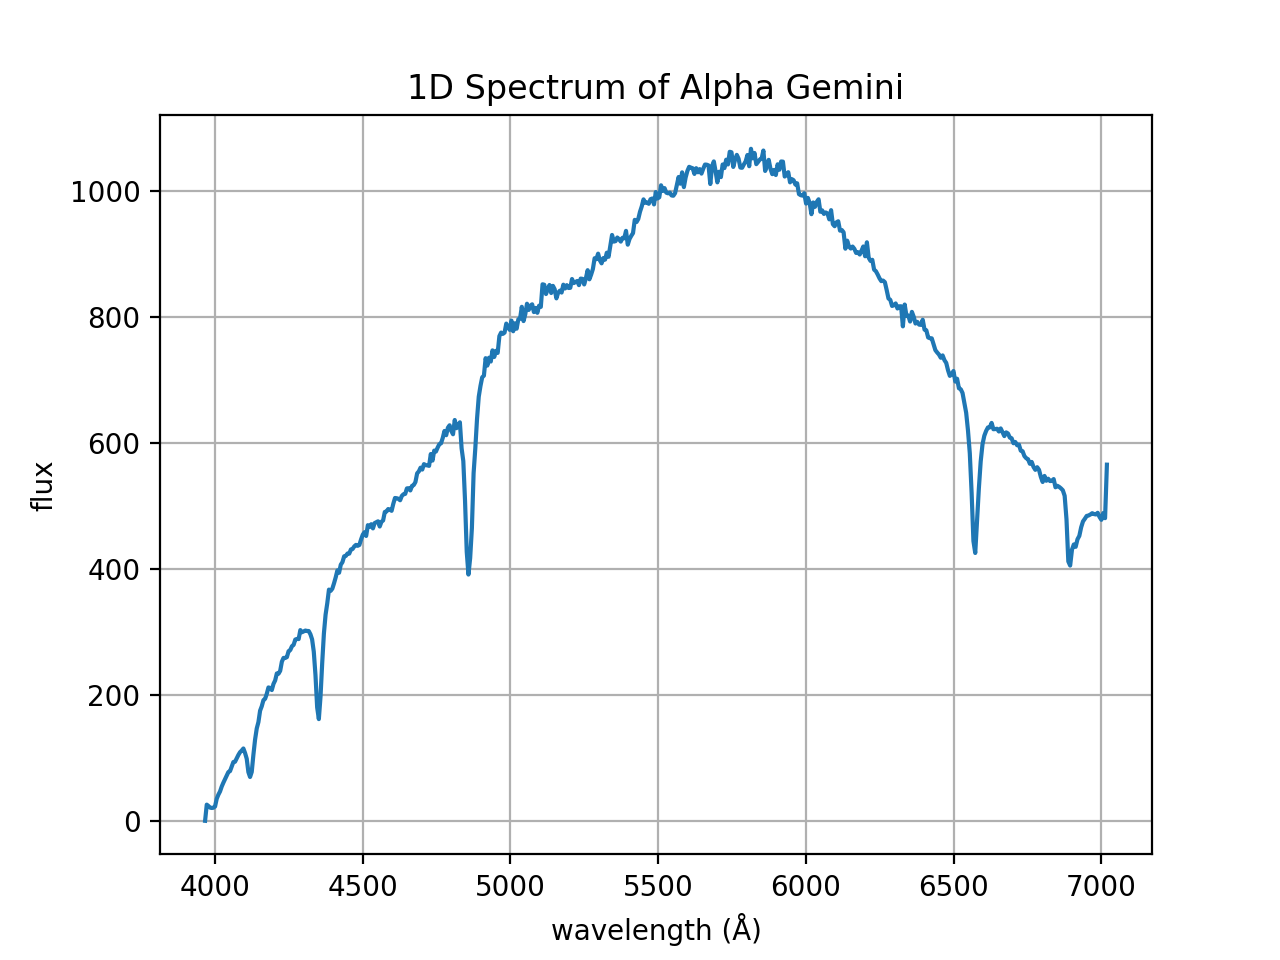

In [23]:
'''
now that we have our wavelengths and intensities we want to read them into a form that we can
use with specutils

we use the class Spectrum1D which has spectral and flux axes - however note that we must set these values
with arrays of astropy.units.Quantities which are arrays that carry a float AND a unit 

you see we use Angstroms for the wavelength unit, but we have not performed a flux calibration, and will later
normalize the spectrum so we will use Janskys (Jy) the non-SI unit of spectral flux as a space holder for if we 
ever choose to calibrate the flux
'''
spec = Spectrum1D(spectral_axis=calib_wavelengths*u.Angstrom, flux=intensity*u.Jy)


## plot the spectrum we defined as spec
plt.figure()
plt.plot(spec.spectral_axis, spec.flux)    # x axis is wavelength y is intensity
plt.xlabel('wavelength (Å)')
plt.ylabel('flux')
plt.grid(True)
plt.title('1D Spectrum of Alpha Gemini')
plt.show()


## Step 4.1 - Fit a continuum to the data and subtract it from your spectrum

<QuantityModel Chebyshev1D(3, c0=-3718.95686263, c1=0.23232413, c2=0.00017089, c3=-0.00000001), input_units=Angstrom, return_units=Jy>


<IPython.core.display.Javascript object>


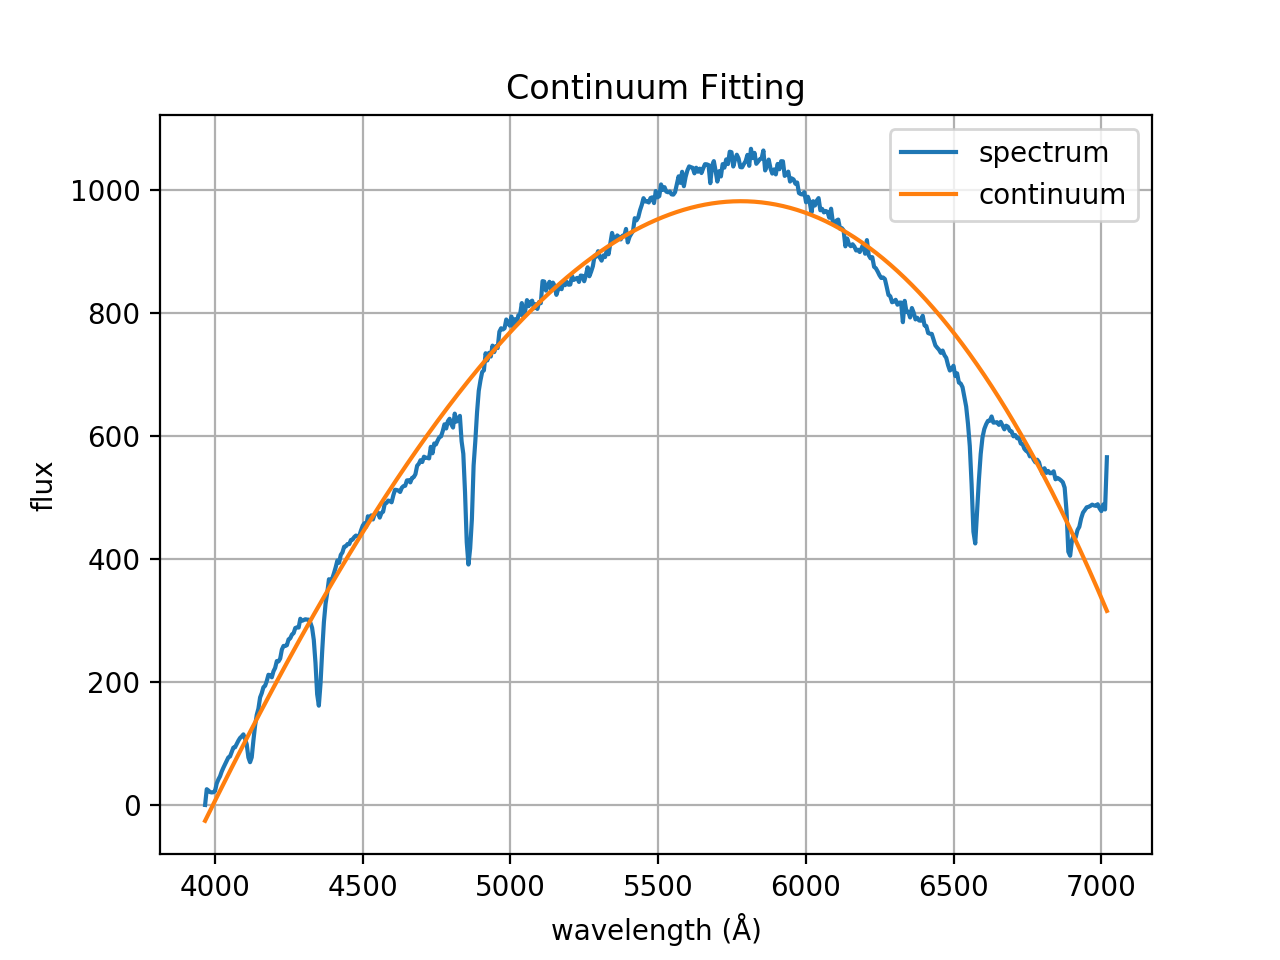

In [24]:
'''
since stars have a black body continuum spectrum, we would like to subtract that out to look specifically
at the absorption and emission lines

we will use specutils fit_generic_continuum to fit a continuum 
''' 

## use specutils.fit_generic_continuum to build a conintuum function to the data
continuum_fit = fit_generic_continuum(spec)
print(continuum_fit)


## plug the wavelengths into your continuum function
intensity_continuum_fitted = continuum_fit(calib_wavelengths*u.Angstrom)

## Plot the original spectrum and the fitted and the continuum
plt.figure()
plt.plot(spec.spectral_axis, spec.flux, label='spectrum')
plt.plot(spec.spectral_axis, intensity_continuum_fitted, label='continuum')
plt.xlabel('wavelength (Å)')
plt.ylabel('flux')
plt.title('Continuum Fitting')
plt.grid(True)
plt.legend()

<IPython.core.display.Javascript object>


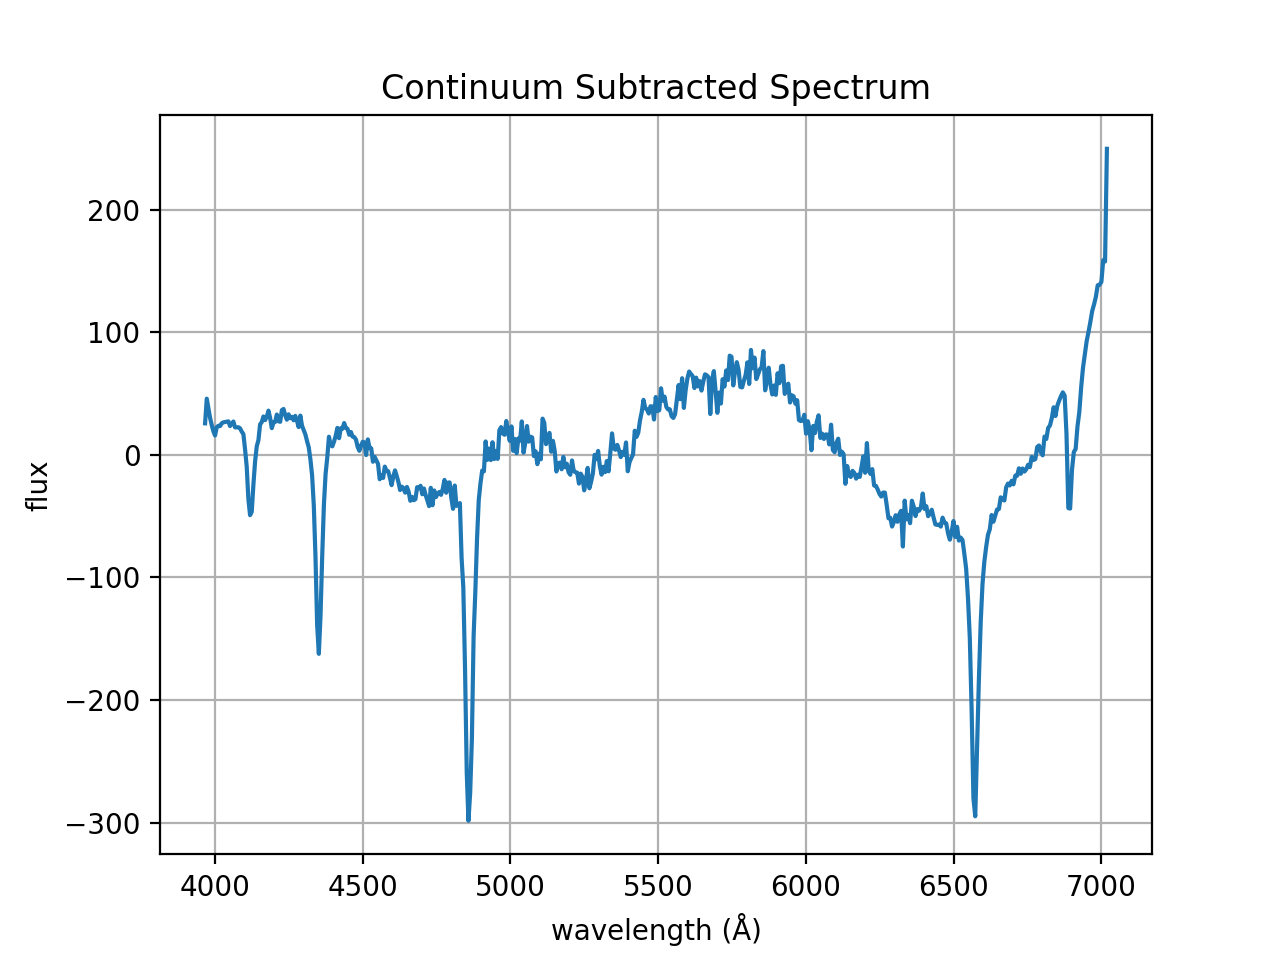

In [25]:
'''
subtract the contiuum from your spectrum so that you have a more or less flat spectrum centered around 0

plot that continuum subtracted spectrum
'''
spec_normalized = spec - intensity_continuum_fitted

# Plot the subtracted spectrum
plt.figure()
plt.plot(spec_normalized.spectral_axis, spec_normalized.flux)
plt.title('Continuum Subtracted Spectrum')
plt.xlabel('wavelength (Å)')
plt.ylabel('flux')
plt.grid(True)

## Step 4.2 - Identify your emission and absorption peaks

In [36]:
'''
we will use specutils find_lines_threshold to pickout the emission and absorption lines

you will need to find a region in your spectrum where it looks like noise to set as a "noise_region"
'''

from specutils.manipulation import noise_region_uncertainty

## looking at my plot, it seems as though between 5600 and 5800 A there is just noise
noise_region = SpectralRegion(5600*u.Angstrom, 5800*u.Angstrom) # use SpectralRegion class to definte this noise region

## make a new spectrum where we will look for peaks that attaches some noise uncertainty
peak_spectrum = noise_region_uncertainty(spec_normalized, noise_region)


from specutils.fitting import find_lines_threshold

'''
the noise_factor is the number you would like to multiply the uncertainty by to say "a peak above this threshold
is significant". a higher noise factor means fewer peaks are selected

here I set the noise factor to 1.5* the unceratinty but we can see that it seems a few peaks are missing 
'''
lines = find_lines_threshold(peak_spectrum, noise_factor=1.5)
# with a lower noise factor you may see it finds repeated peaks once you fit each peak below

## this will give you which lines the program finds both emission and absorption, the wavelength center of the peak,
## and the array index of the center
emissions = lines[lines['line_type'] == 'emission']
absorptions = lines[lines['line_type'] == 'absorption'] 

print(emissions )

print(absorptions )


   line_center    line_type line_center_index
     Angstrom                                
----------------- --------- -----------------
7018.566533016082  emission                 0
   line_center     line_type  line_center_index
     Angstrom                                  
------------------ ---------- -----------------
 6572.944677998686 absorption                72
4857.7272065401485 absorption               359
 4351.370161667439 absorption               447


Absorption peak: 0 
 mean: 6570.735428786242 Angstrom 
 FWHM 78.3105038671811 Angstrom
Absorption peak: 1 
 mean: 4859.653947457422 Angstrom 
 FWHM 36.57179453929525 Angstrom
Absorption peak: 2 
 mean: 4351.189852832347 Angstrom 
 FWHM 24.0257014865697 Angstrom


<IPython.core.display.Javascript object>


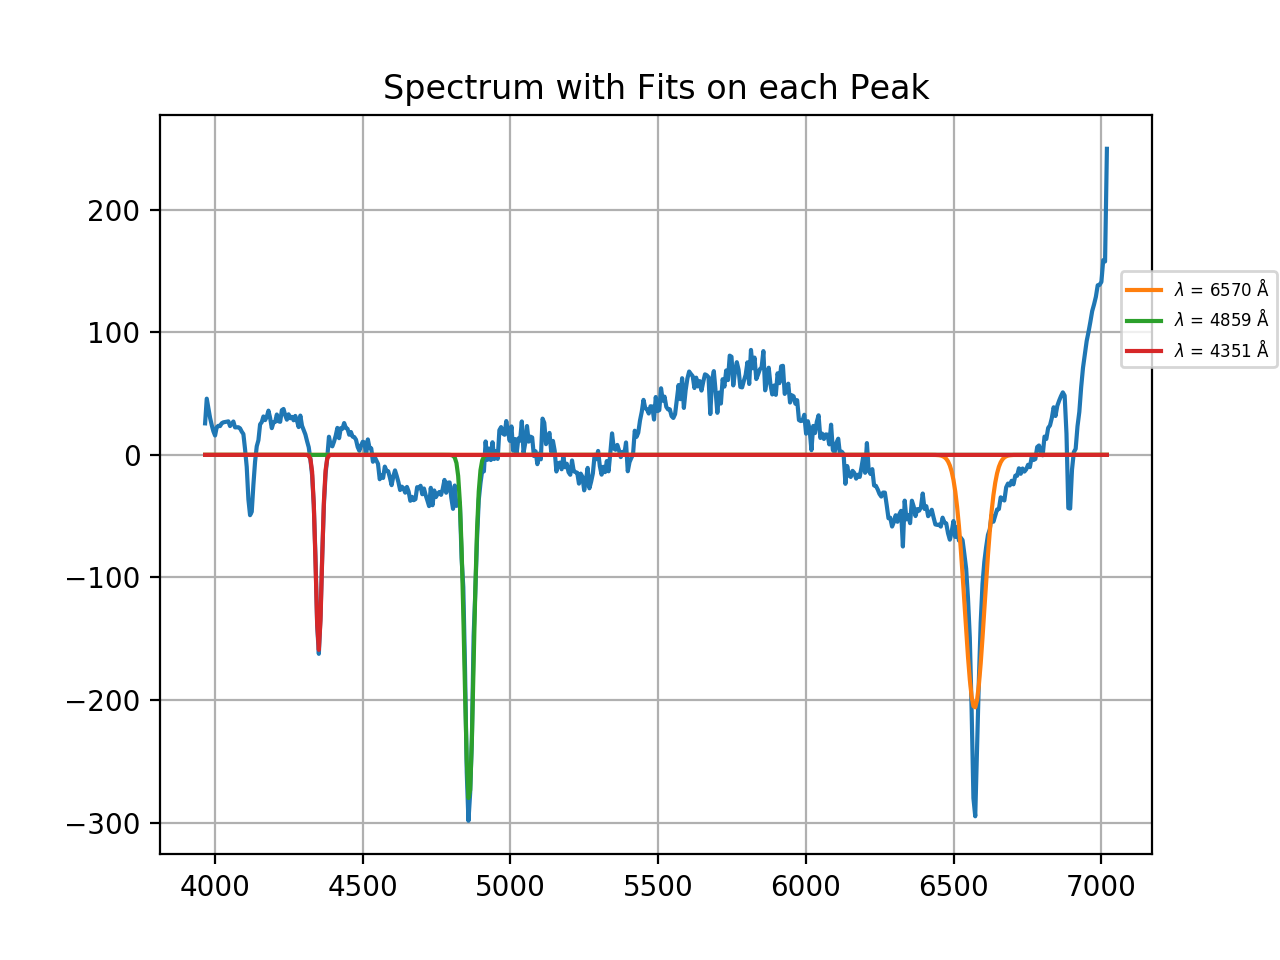

In [37]:
'''
now that we have the centers of each line, we will use these to fit gaussians to each line so we can extract a mean
and a width (as FWHM)
'''

from astropy.modeling import models
from astropy import units as u

from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines

# define your array to store all of the arrays with points for a fit for each peak
all_peak_fits = []

# define your array to store the parameters of each fit 
all_gaus_fits = []

for i in range(len(absorptions)):
   
    # initialize your gaussian fit -- I approximated values for amplitude and stddev by looking a tthe plot
    # then it will loop through each peak by its mean
    gaus_init = models.Gaussian1D(amplitude=-100*u.Jy, mean=absorptions[i][0], stddev=20*u.Angstrom)
    
    # fit the spectrum with the initialized gaussian looking only in a window of 100Å before and after each peak
    # this will only fit one peak and not confuse the program to fit the entire spectrum
    # gaus_fit returns the parameters of this fit
    gaus_fit = fit_lines(spec_normalized, gaus_init, window = 
                         SpectralRegion(absorptions[i][0]-100*u.Angstrom,absorptions[i][0]+100*u.Angstrom))
    
    # peak fit applies those parameters to the wavelengths of the spectral axis
    peak_fit = gaus_fit(spec_normalized.spectral_axis)
    
    # append your findings
    all_gaus_fits.append(gaus_fit)
    all_peak_fits.append(peak_fit)

    print('Absorption peak:',i,'\n','mean:',gaus_fit.mean[0],'Angstrom', '\n','FWHM',gaus_fit.fwhm)


plt.figure()
plt.plot(spec_normalized.spectral_axis, spec_normalized.flux)

# plot each gaussian fit
for i in range(len(absorptions)):
    plt.plot(spec_normalized.spectral_axis, all_peak_fits[i],label='$\lambda$ = %d Å' %all_gaus_fits[i].mean[0])
    
plt.title('Spectrum with Fits on each Peak')
plt.grid(True)
plt.legend( bbox_to_anchor=(0.96, 0.8),prop={'size': 6} )